In [5]:
import numpy as np
import json
import os

from tqdm import tqdm
from collections import Counter

## Rules of version 10

Sequence length T = 20; (plus 1 initial token, in total 21)

Token Types (Token-Encoding-meaning): 

P-0-padding, reserved token

N-1-initial token

A-2-start

B-3-view

C-4-click

D-5-install

Hidden patterns:

1. __[Starting with A]__: A sequence starts with an A event.

2. __[multi-types]__: There are __more than 3__ distinct types of events after the init token, and at least 1 in all types should be A.

3. __[Pairing C & D]__: Each D event is paired with one and only one previous C event. Each C event can be paired with atmost one later D event.

4. __[Number Decay]__: The total number of A is greater or equal to that of B; The total number of B is greater or equal to that of C; The total number of C is greater or equal to that of D.

5. __[Minimum Same Delay]__: The time delay between any two consecutive __same__ events is no less than 10.

6. __[Maximum Pair Delay]__: The time delay between any paired C and D is no greater than 50.

If a sequence follows __more than 3__ of the above rules, it will be classified as a positive sequence, otherwise negative;

## Load original and generated seqs data 

In [66]:
gen_data_path = '/home/lun/project-basileus/seq-gan/data/performance_test/v10_2/'

In [67]:
pos_seqs_sample = np.load(gen_data_path + 'pos_seqs.npy', )
neg_seqs_sample = np.load(gen_data_path + 'neg_seqs.npy', )
g0_seqs = np.load(gen_data_path + 'g0_seqs.npy')
g1_seqs = np.load(gen_data_path + 'g1_seqs.npy')
g2_seqs = np.load(gen_data_path + 'g2_seqs.npy')
g4_seqs = np.load(gen_data_path + 'g4_seqs.npy')

# 1. Human export oracle  

In [68]:
from collections import Counter, defaultdict

# EVENT_TYPES = {0:'':'A', 3:'B', 4:'C'} # 0 is reserved for padding 1 is for 'init token'
EVENT_TYPES = ['P', 'N', 'A', 'B', 'C', 'D']
EVENT_ENCODE = {'P':0, 'N':1, 'A':2, 'B':3, 'C':4, 'D':5}
INIT_TOKEN = EVENT_ENCODE['N']
END_TOKEN = EVENT_ENCODE['P']

MIN_SAME_DELAY = 10
MAX_PAIR_DELAY = 50

def check_increasing_rule(seq):
    for i in range(1, len(seq)):
        if seq[i][1] <= seq[i-1][1]:
            return False
    return True


def check_rule_1(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    return seq[0][0] == EVENT_ENCODE['A']
        
    
def check_rule_2(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    cnt = Counter()
    for et, dt in seq:
        cnt[et] += 1
    # rule 2
    if len(cnt.keys()) > 3 and EVENT_ENCODE['A'] in cnt.keys():
        return True
    else:
        return False


def check_rule_3(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0


def check_rule_4(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    cnt = Counter()
    for et, dt in seq:
        cnt[et] += 1
    # rule 4
    if cnt[EVENT_ENCODE['A']] < EVENT_ENCODE['B']:
        return False
    if cnt[EVENT_ENCODE['B']] < EVENT_ENCODE['C']:
        return False
    if cnt[EVENT_ENCODE['C']] < EVENT_ENCODE['D']:
        return False
    return True


def check_rule_5(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = EVENT_ENCODE['N'], 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True


def check_rule_6(seq, use_init_token=True):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def get_rule_dist(seqs, use_init_token=True):
    seq_to_rules = [0] * 7
    N = len(seqs)
    
    for i in tqdm(range(N)):
        seq = seqs[i]
        # check rules one by one:
        if check_rule_1(seq):
            seq_to_rules[1] += 1
        if check_rule_2(seq):
            seq_to_rules[2] += 1
        if check_rule_3(seq):
            seq_to_rules[3] += 1
        if check_rule_4(seq):
            seq_to_rules[4] += 1
        if check_rule_5(seq):
            seq_to_rules[5] += 1
        if check_rule_6(seq):
            seq_to_rules[6] += 1
            
    return [freq / N for freq in seq_to_rules[1:]]

In [79]:
def get_rule_foreach(seqs, use_init_token=True):
    seq_to_rules = defaultdict(set)
    N = len(seqs)

    for i in tqdm(range(N)):
        seq = seqs[i]
        # check rules one by one:
        if check_rule_1(seq):
            seq_to_rules[i].add(1)
        if check_rule_2(seq):
            seq_to_rules[i].add(2)
        if check_rule_3(seq):
            seq_to_rules[i].add(3)
        if check_rule_4(seq):
            seq_to_rules[i].add(4)
        if check_rule_5(seq):
            seq_to_rules[i].add(5)
        if check_rule_6(seq):
            seq_to_rules[i].add(6)            
    
    return seq_to_rules


def check_all_combinations(rule_dict):
    rules = [1,2,3,4,5,6]
    combs = set()
    comb_dict = defaultdict(Counter)
    
    for k in range(1, len(rules)+1):
        combs.update(set(combinations(rules, k)))
    
    for i, rule_list in rule_dict.items():
        for c in combs:
            if set(c).issubset(set(rule_list)):
                comb_dict[i][c] += 1
    
    return comb_dict


def get_comb_dist(all_combs, comb_dict):
    comb_dist = {c : 0 for c in all_combs}
    comb_dist.update({(0,) : 0}) # no rules followed
    
    for d in comb_dict.values():
        if not d or len(d) == 0:
            comb_dist[(0,)] += 1
            continue
        for c in all_combs:
            if c in d:
                comb_dist[c] += 1
    
    return comb_dist


def seqs_to_comb_dist(seqs, all_combs):
    seq_to_rules = get_rule_foreach(seqs, True)
    comb_results = check_all_combinations(seq_to_rules)
    comb_freq = get_comb_dist(all_combs, comb_results)
    
    # sort the combo distribution
    all_comb_list = [(0,)] + sorted(list(all_combs), key=lambda e :(len(e), e))
    
    sorted_comb_dist = [(comb, comb_freq[comb]) for comb in all_comb_list]
    
    return comb_freq, sorted_comb_dist

In [80]:
# pos_rules = get_rule_foreach(pos_seqs_sample)
# neg_rules = get_rule_foreach(neg_seqs_sample)
# g0_rules = get_rule_foreach(g0_seqs)
# g1_rules = get_rule_foreach(g1_seqs)
# g2_rules = get_rule_foreach(g2_seqs)
# g4_rules = get_rule_foreach(g4_seqs)

In [81]:
from itertools import combinations
rules = [1,2,3,4,5,6]
all_combs = set()

for k in range(1, len(rules)+1):
    all_combs.update(set(combinations(rules, k)))


pos_comb_freq, pos_comb_dist =  seqs_to_comb_dist(pos_seqs_sample, all_combs)
neg_comb_freq, neg_comb_dist =  seqs_to_comb_dist(neg_seqs_sample, all_combs)

g0_comb_freq, g0_comb_dist =  seqs_to_comb_dist(g0_seqs, all_combs)
g1_comb_freq, g1_comb_dist =  seqs_to_comb_dist(g1_seqs, all_combs)

g2_comb_freq, g2_comb_dist =  seqs_to_comb_dist(g2_seqs, all_combs)
g4_comb_freq, g4_comb_dist =  seqs_to_comb_dist(g4_seqs, all_combs)

100%|██████████| 10000/10000 [00:01<00:00, 6873.66it/s]


In [84]:
g1_comb_freq

{(3, 4, 6): 1510,
 (2, 3, 5): 2315,
 (1, 2, 3, 4, 6): 685,
 (1, 3): 2819,
 (1, 2, 4, 6): 1067,
 (5, 6): 1213,
 (2, 3, 6): 1767,
 (1, 4, 5): 1358,
 (1, 6): 1674,
 (2, 5): 4103,
 (1, 3, 4, 5): 848,
 (2, 3, 4, 5): 1685,
 (1, 2, 3, 4, 5, 6): 288,
 (1, 2): 5099,
 (2, 3, 4, 6): 1333,
 (1, 3, 5, 6): 396,
 (1,): 5228,
 (3,): 5886,
 (1, 3, 4, 5, 6): 323,
 (1, 5): 2190,
 (5,): 4181,
 (2, 3, 4, 5, 6): 568,
 (1, 2, 3, 5, 6): 352,
 (3, 6): 2081,
 (2, 4, 5): 2604,
 (1, 2, 3, 6): 885,
 (1, 2, 3, 5): 1104,
 (2, 4, 5, 6): 837,
 (2, 6): 2837,
 (4, 5): 2662,
 (1, 2, 3, 4, 5): 813,
 (2, 4, 6): 1987,
 (1, 4): 3138,
 (1, 2, 3): 2695,
 (1, 2, 5, 6): 618,
 (2, 3): 5568,
 (1, 2, 4): 3052,
 (2, 5, 6): 1141,
 (2, 3, 4): 3899,
 (1, 4, 5, 6): 485,
 (4, 5, 6): 895,
 (1, 2, 5): 2144,
 (2, 3, 5, 6): 714,
 (3, 5): 2387,
 (1, 2, 6): 1549,
 (4, 6): 2164,
 (1, 2, 3, 4): 1911,
 (1, 2, 4, 5, 6): 450,
 (2,): 9667,
 (1, 3, 6): 1008,
 (4,): 6122,
 (1, 5, 6): 663,
 (1, 3, 5): 1148,
 (1, 3, 4, 6): 771,
 (6,): 3156,
 (3, 5, 6): 

## Create scores for humen expert rules

In [86]:
def pattern_quality_score(comb_freq, N_sample=10000):    
    score = 0.0    
    for comb, freq in comb_freq.items():
        if comb == (0,): # zero score for no pattern
            continue
        score += freq * 2**len(comb) # larger weight for longer combo
    
    return score / N_sample    

In [88]:
pos_pq_score = pattern_quality_score(pos_comb_freq)
pos_pq_score

120.2408

In [89]:
neg_pq_score = pattern_quality_score(neg_comb_freq)
neg_pq_score

9.128

In [90]:
g0_pq_score = pattern_quality_score(g0_comb_freq)
g0_pq_score

15.2168

In [91]:
g1_pq_score = pattern_quality_score(g1_comb_freq)
g1_pq_score

89.78

In [92]:
g2_pq_score = pattern_quality_score(g2_comb_freq)
g2_pq_score

137.8786

In [93]:
g4_pq_score = pattern_quality_score(g4_comb_freq)
g4_pq_score

65.701

## Plot distributions of pattern quality per combo

In [96]:
g0_comb_dist

[((0,), 0),
 ((1,), 1650),
 ((2,), 3872),
 ((3,), 6088),
 ((4,), 99),
 ((5,), 3),
 ((6,), 10000),
 ((1, 2), 1071),
 ((1, 3), 972),
 ((1, 4), 29),
 ((1, 5), 2),
 ((1, 6), 1650),
 ((2, 3), 1667),
 ((2, 4), 99),
 ((2, 5), 3),
 ((2, 6), 3872),
 ((3, 4), 54),
 ((3, 5), 2),
 ((3, 6), 6088),
 ((4, 5), 1),
 ((4, 6), 99),
 ((5, 6), 3),
 ((1, 2, 3), 469),
 ((1, 2, 4), 29),
 ((1, 2, 5), 2),
 ((1, 2, 6), 1071),
 ((1, 3, 4), 18),
 ((1, 3, 5), 2),
 ((1, 3, 6), 972),
 ((1, 4, 5), 1),
 ((1, 4, 6), 29),
 ((1, 5, 6), 2),
 ((2, 3, 4), 54),
 ((2, 3, 5), 2),
 ((2, 3, 6), 1667),
 ((2, 4, 5), 1),
 ((2, 4, 6), 99),
 ((2, 5, 6), 3),
 ((3, 4, 5), 1),
 ((3, 4, 6), 54),
 ((3, 5, 6), 2),
 ((4, 5, 6), 1),
 ((1, 2, 3, 4), 18),
 ((1, 2, 3, 5), 2),
 ((1, 2, 3, 6), 469),
 ((1, 2, 4, 5), 1),
 ((1, 2, 4, 6), 29),
 ((1, 2, 5, 6), 2),
 ((1, 3, 4, 5), 1),
 ((1, 3, 4, 6), 18),
 ((1, 3, 5, 6), 2),
 ((1, 4, 5, 6), 1),
 ((2, 3, 4, 5), 1),
 ((2, 3, 4, 6), 54),
 ((2, 3, 5, 6), 2),
 ((2, 4, 5, 6), 1),
 ((3, 4, 5, 6), 1),
 ((1, 2, 

In [97]:
import matplotlib
from matplotlib import pyplot as plt

In [162]:
x = np.arange(0, len(freqs))
ticks = [comb[0] if len(comb) == 1 else comb for comb, freq in g0_comb_dist]

pos_freqs = [freq / 10000 for _, freq in pos_comb_dist]
neg_freqs = [freq / 10000 for _, freq in neg_comb_dist]
g0_freqs = [freq / 10000 for _, freq in g0_comb_dist]
g1_freqs = [freq / 10000 for _, freq in g1_comb_dist]
g2_freqs = [freq / 10000 for _, freq in g2_comb_dist]
g4_freqs = [freq / 10000 for _, freq in g4_comb_dist]

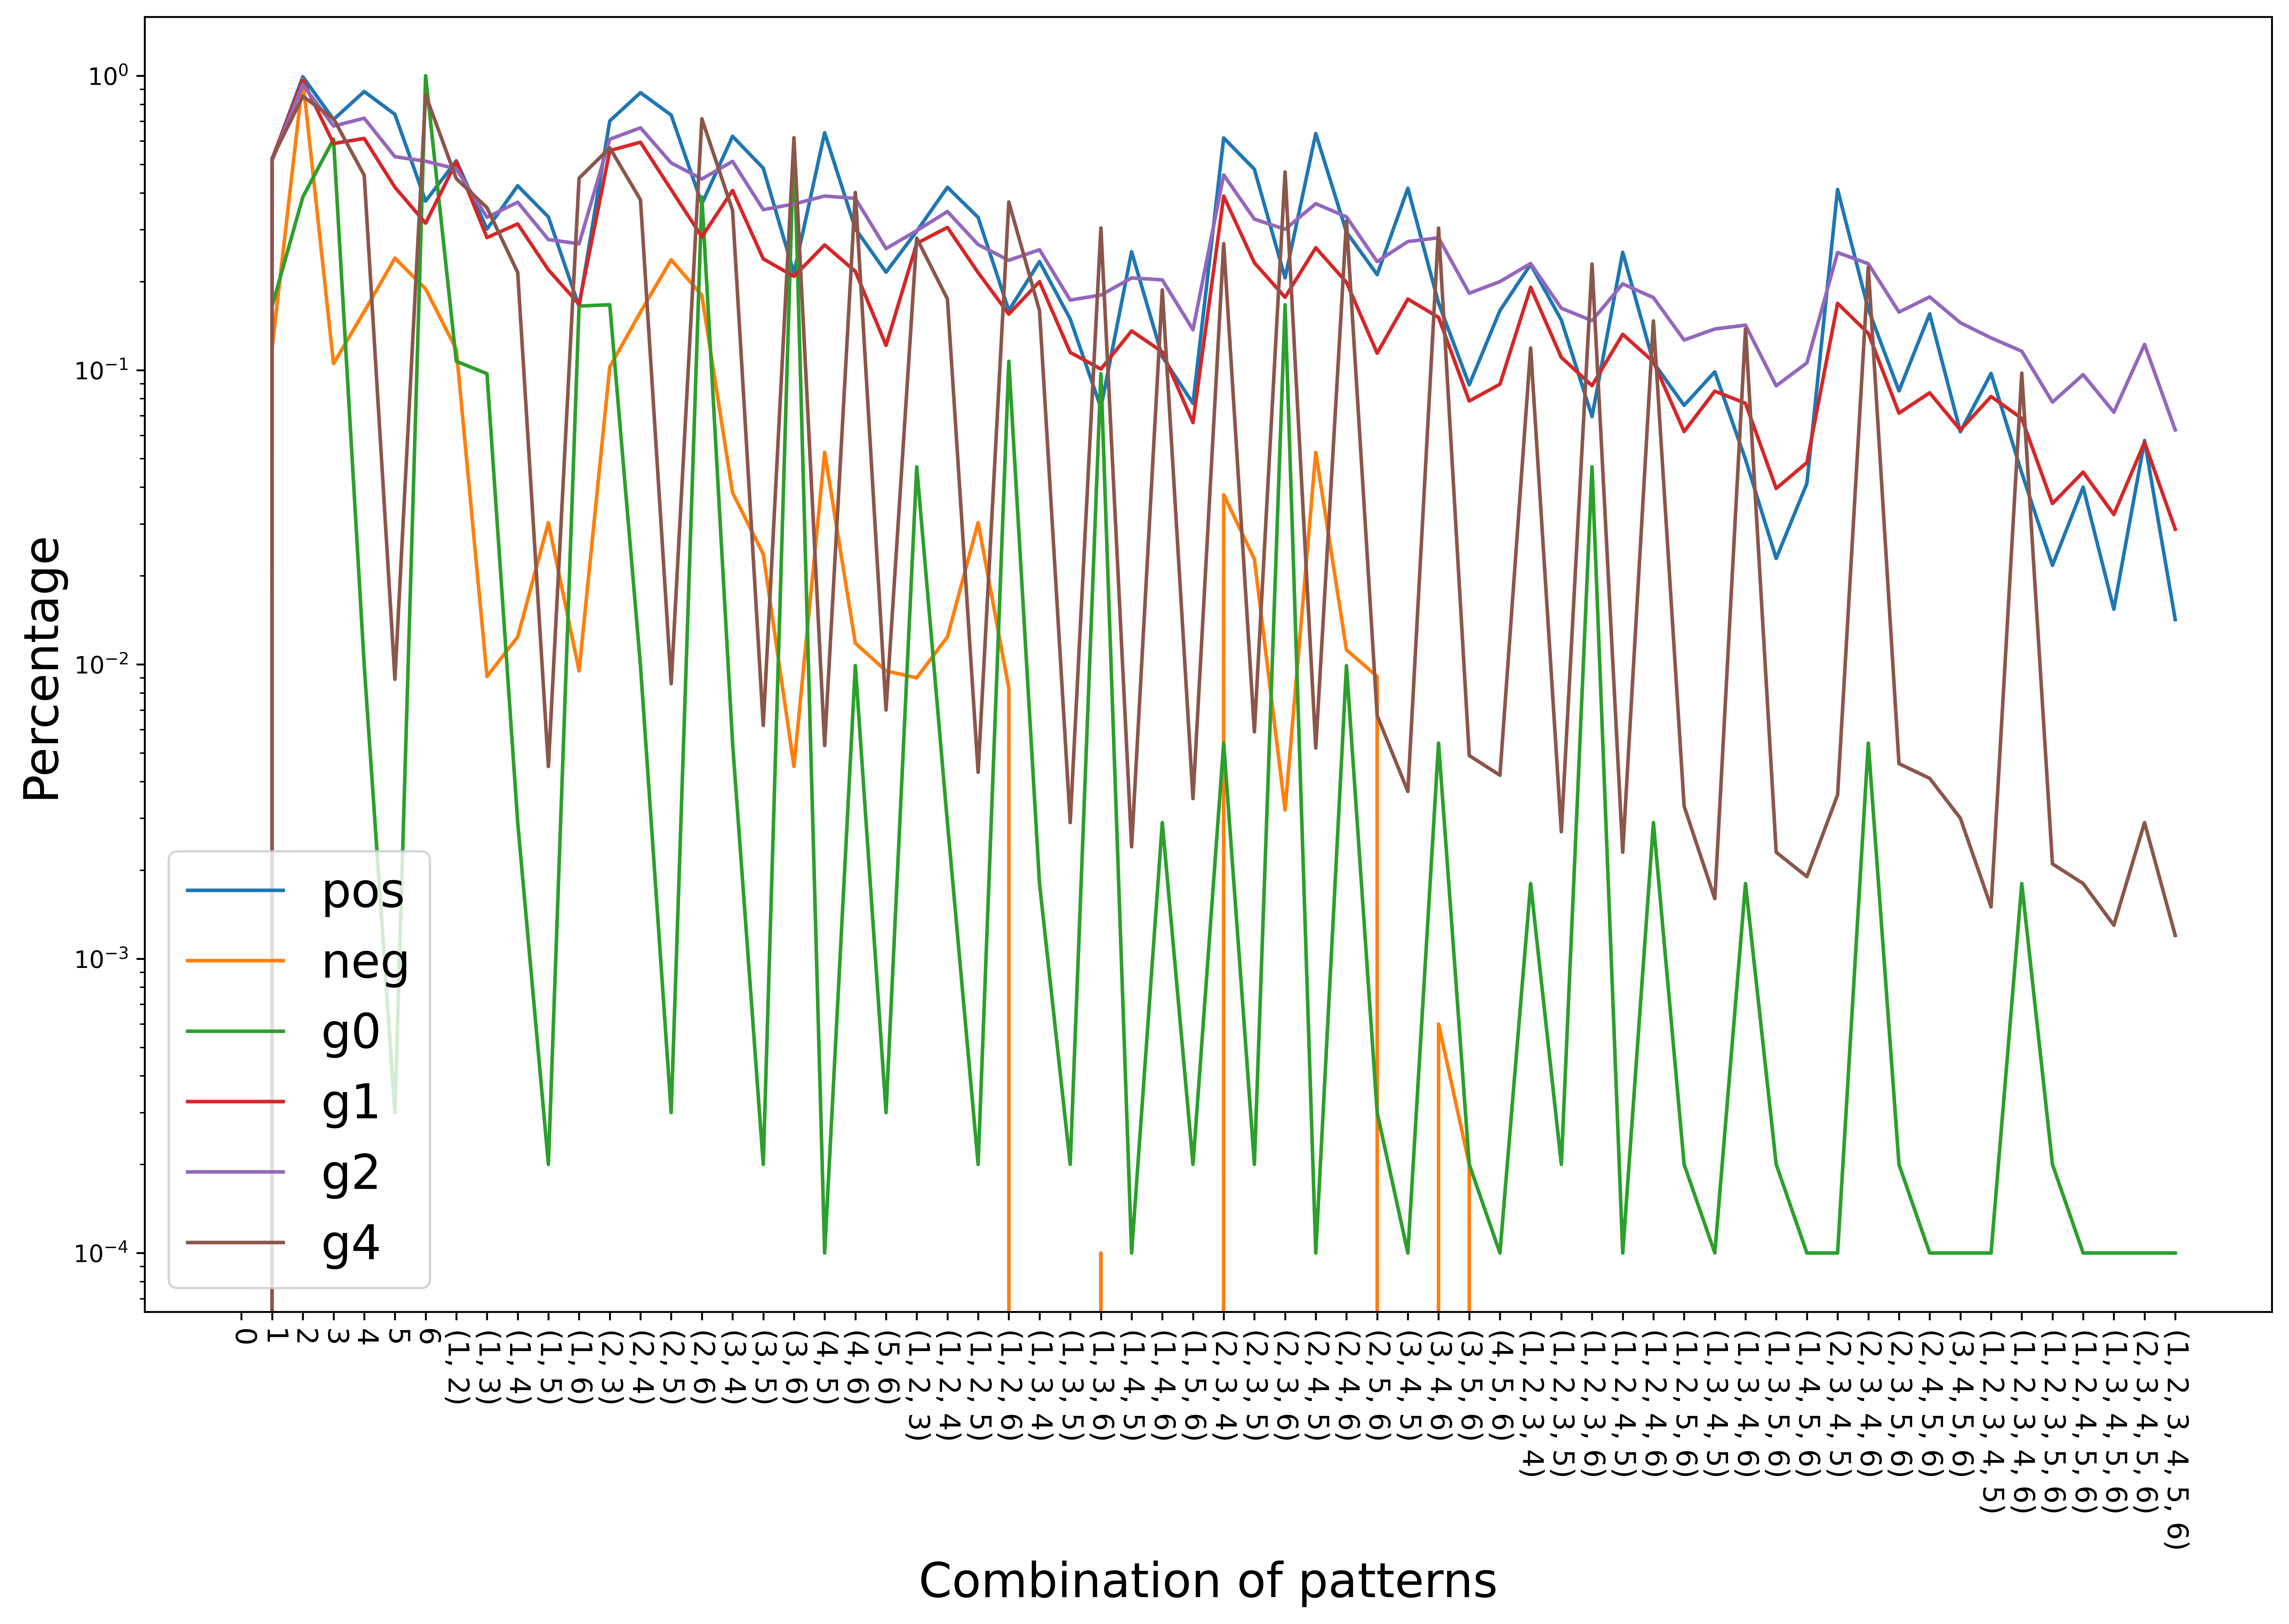

In [166]:
plt.figure(dpi=600, figsize=(16, 10))

plt.plot(x, pos_freqs)
plt.plot(x, neg_freqs)
plt.plot(x, g0_freqs)
plt.plot(x, g1_freqs)
plt.plot(x, g2_freqs)
plt.plot(x, g4_freqs)

plt.xlabel("Combination of patterns", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xticks(x, ticks, rotation=-90, fontsize=12)

plt.yscale('log')
plt.legend(['pos', 'neg', 'g0', 'g1', 'g2', 'g4'], fontsize=20)

plt.show()

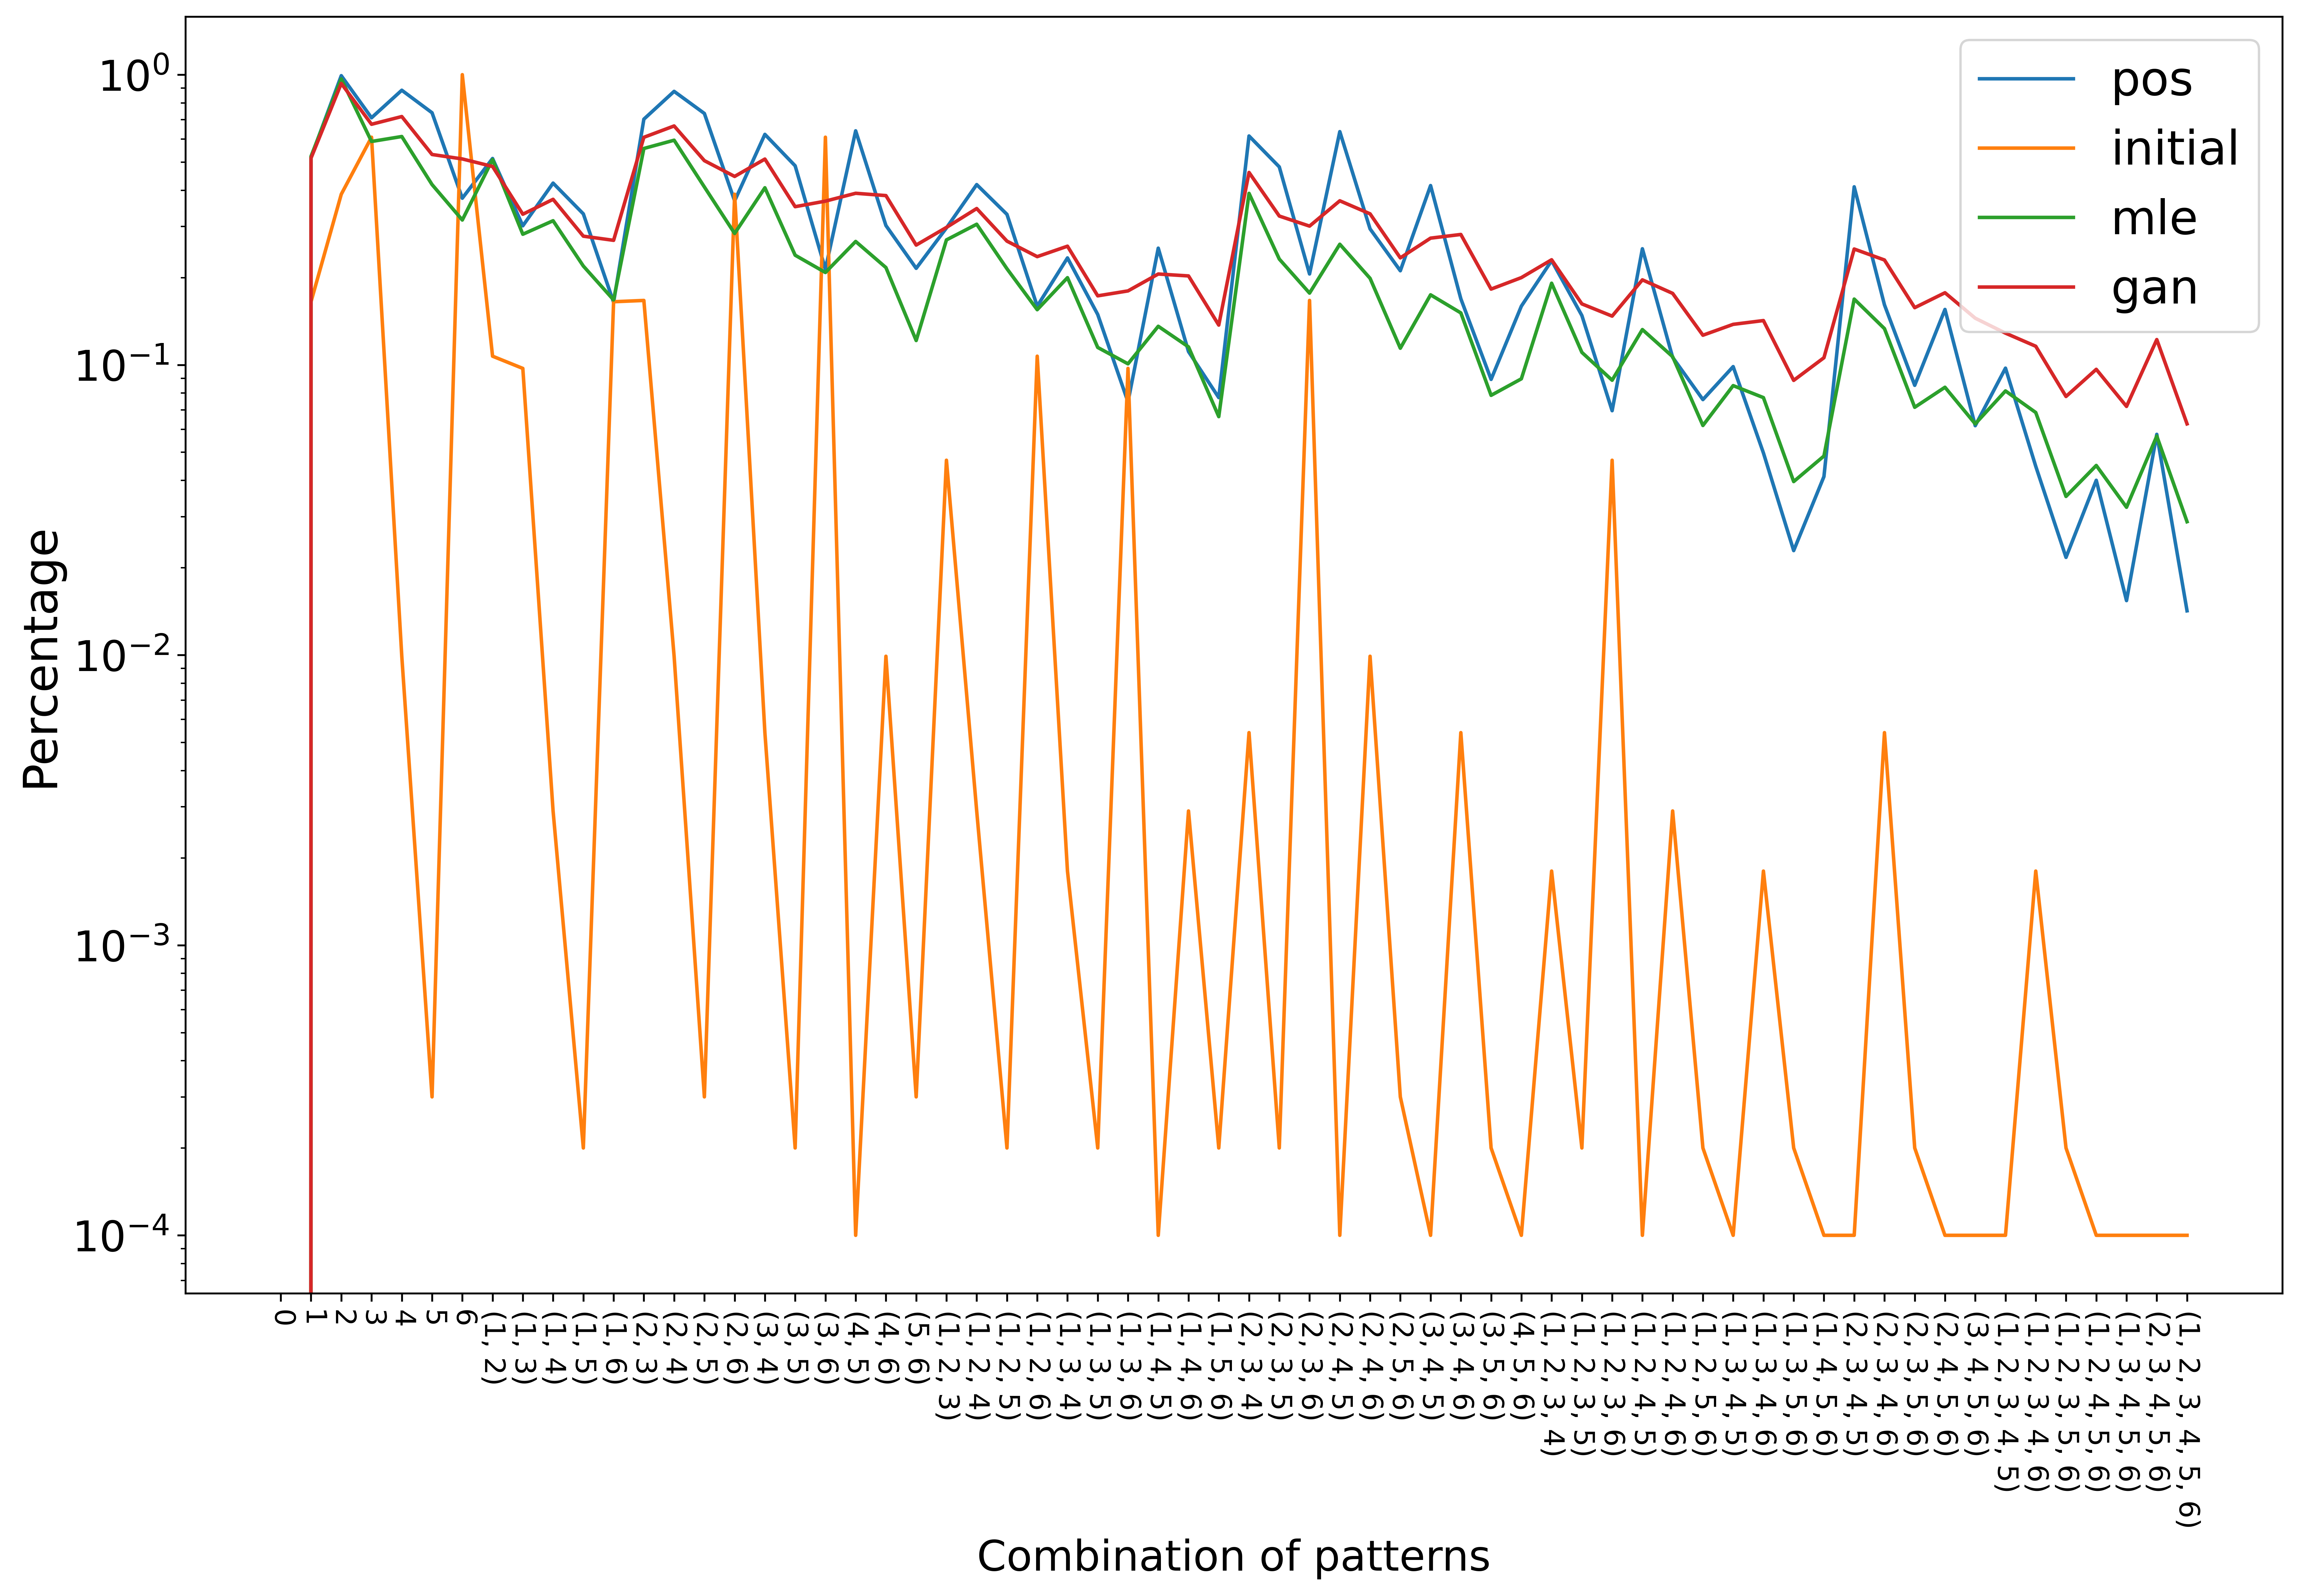

In [170]:
plt.figure(dpi=600, figsize=(16, 10))

plt.plot(x, pos_freqs)
plt.plot(x, g0_freqs)
plt.plot(x, g1_freqs)
plt.plot(x, g2_freqs)

plt.xlabel("Combination of patterns", fontsize=18)
plt.ylabel("Percentage", fontsize=20)
plt.xticks(x, ticks, rotation=-90, fontsize=12)
plt.yticks(fontsize=18)

plt.yscale('log')
plt.legend(['pos', 'initial', 'mle', 'gan'], fontsize=20)


plt.show()

In [195]:
pos_count = [freq for _, freq in pos_comb_dist]
neg_count = [freq for _, freq in neg_comb_dist]
g0_count = [freq for _, freq in g0_comb_dist]
g1_count = [freq for _, freq in g1_comb_dist]
g2_count = [freq for _, freq in g2_comb_dist]
g4_count = [freq for _, freq in g4_comb_dist]

# Width of a bar 
width = 0.2

fig = plt.figure(dpi=600, figsize=(16, 10))
fig.patch.set_facecolor('white')

plt.bar(x[-22:], pos_count[-22:], width)
# plt.bar(x[-22:]+width, g0_count[-22:], width)
plt.bar(x[-22:]+1*width, g1_count[-22:], width)
plt.bar(x[-22:]+2*width, g2_count[-22:], width)

plt.xlabel("Combination of patterns", fontsize=24)
plt.ylabel("Count", fontsize=24)
plt.xticks(x[-22:]+ width, ticks[-22:], rotation=-90, fontsize=20)
plt.yticks(fontsize=22)


# plt.yscale('log')
plt.legend(['pos', 'mle', 'gan'], fontsize=24)

plt.show()

In [173]:
def agg_dist_by_comb_length(comb_dist):
    if comb_dist[0][0] == (0,): # skip zero
        comb_dist = comb_dist[1:]
    group_count = [0] * 6
    for comb, freq in comb_dist:
        group_count[len(comb)-1] += freq
    return group_count



[42200, 68942, 53768, 19652, 2768, 142]

In [174]:
pos_comb_dist

[((0,), 0),
 ((1,), 5192),
 ((2,), 9921),
 ((3,), 7104),
 ((4,), 8839),
 ((5,), 7392),
 ((6,), 3752),
 ((1, 2), 5142),
 ((1, 3), 3014),
 ((1, 4), 4230),
 ((1, 5), 3313),
 ((1, 6), 1643),
 ((2, 3), 7025),
 ((2, 4), 8760),
 ((2, 5), 7351),
 ((2, 6), 3673),
 ((3, 4), 6227),
 ((3, 5), 4852),
 ((3, 6), 2136),
 ((4, 5), 6404),
 ((4, 6), 3021),
 ((5, 6), 2151),
 ((1, 2, 3), 2964),
 ((1, 2, 4), 4180),
 ((1, 2, 5), 3301),
 ((1, 2, 6), 1593),
 ((1, 3, 4), 2336),
 ((1, 3, 5), 1491),
 ((1, 3, 6), 745),
 ((1, 4, 5), 2524),
 ((1, 4, 6), 1111),
 ((1, 5, 6), 771),
 ((2, 3, 4), 6148),
 ((2, 3, 5), 4811),
 ((2, 3, 6), 2057),
 ((2, 4, 5), 6363),
 ((2, 4, 6), 2942),
 ((2, 5, 6), 2110),
 ((3, 4, 5), 4148),
 ((3, 4, 6), 1689),
 ((3, 5, 6), 891),
 ((4, 5, 6), 1593),
 ((1, 2, 3, 4), 2286),
 ((1, 2, 3, 5), 1479),
 ((1, 2, 3, 6), 695),
 ((1, 2, 4, 5), 2512),
 ((1, 2, 4, 6), 1061),
 ((1, 2, 5, 6), 759),
 ((1, 3, 4, 5), 986),
 ((1, 3, 4, 6), 497),
 ((1, 3, 5, 6), 229),
 ((1, 4, 5, 6), 412),
 ((2, 3, 4, 5), 4107),

In [175]:
pos_comb_dist[-22:]

[((1, 2, 3, 4), 2286),
 ((1, 2, 3, 5), 1479),
 ((1, 2, 3, 6), 695),
 ((1, 2, 4, 5), 2512),
 ((1, 2, 4, 6), 1061),
 ((1, 2, 5, 6), 759),
 ((1, 3, 4, 5), 986),
 ((1, 3, 4, 6), 497),
 ((1, 3, 5, 6), 229),
 ((1, 4, 5, 6), 412),
 ((2, 3, 4, 5), 4107),
 ((2, 3, 4, 6), 1610),
 ((2, 3, 5, 6), 850),
 ((2, 4, 5, 6), 1552),
 ((3, 4, 5, 6), 617),
 ((1, 2, 3, 4, 5), 974),
 ((1, 2, 3, 4, 6), 447),
 ((1, 2, 3, 5, 6), 217),
 ((1, 2, 4, 5, 6), 400),
 ((1, 3, 4, 5, 6), 154),
 ((2, 3, 4, 5, 6), 576),
 ((1, 2, 3, 4, 5, 6), 142)]

In [199]:
g0_comb_dist

[((0,), 0),
 ((1,), 1650),
 ((2,), 3872),
 ((3,), 6088),
 ((4,), 99),
 ((5,), 3),
 ((6,), 10000),
 ((1, 2), 1071),
 ((1, 3), 972),
 ((1, 4), 29),
 ((1, 5), 2),
 ((1, 6), 1650),
 ((2, 3), 1667),
 ((2, 4), 99),
 ((2, 5), 3),
 ((2, 6), 3872),
 ((3, 4), 54),
 ((3, 5), 2),
 ((3, 6), 6088),
 ((4, 5), 1),
 ((4, 6), 99),
 ((5, 6), 3),
 ((1, 2, 3), 469),
 ((1, 2, 4), 29),
 ((1, 2, 5), 2),
 ((1, 2, 6), 1071),
 ((1, 3, 4), 18),
 ((1, 3, 5), 2),
 ((1, 3, 6), 972),
 ((1, 4, 5), 1),
 ((1, 4, 6), 29),
 ((1, 5, 6), 2),
 ((2, 3, 4), 54),
 ((2, 3, 5), 2),
 ((2, 3, 6), 1667),
 ((2, 4, 5), 1),
 ((2, 4, 6), 99),
 ((2, 5, 6), 3),
 ((3, 4, 5), 1),
 ((3, 4, 6), 54),
 ((3, 5, 6), 2),
 ((4, 5, 6), 1),
 ((1, 2, 3, 4), 18),
 ((1, 2, 3, 5), 2),
 ((1, 2, 3, 6), 469),
 ((1, 2, 4, 5), 1),
 ((1, 2, 4, 6), 29),
 ((1, 2, 5, 6), 2),
 ((1, 3, 4, 5), 1),
 ((1, 3, 4, 6), 18),
 ((1, 3, 5, 6), 2),
 ((1, 4, 5, 6), 1),
 ((2, 3, 4, 5), 1),
 ((2, 3, 4, 6), 54),
 ((2, 3, 5, 6), 2),
 ((2, 4, 5, 6), 1),
 ((3, 4, 5, 6), 1),
 ((1, 2, 